# Introduction to Bayesian Modeling

-----

In this notebook, we introduce probabilistic programming by employing [Bayesian linear regression][wbm]. The Bayesian approach uses observations or data, to modify prior assumptions, which produces posterior distributions for our model parameters. In this manner, we not only obtain the best model parameters but also probability density functions for these parameters (which provides robust error estimation). To compute the model likelihoods and the posterior distributions, we will employ the [PyMC3][p3l] library.

-----
[wbm]: https://en.wikipedia.org/wiki/Bayesian_linear_regression
[p3l]: http://docs.pymc.io

## Table of Contents

[Sample Model](#Sample-Model)

[Bayesian Analysis](#Bayesian-Analysis)

- [Prior Visualization](#Prior-Visualization)
- [Sample Posterior](#Sample-Posterior)
- [Trace Analysis](#Trace-Analysis)
- [Posterior Distributions](#Posterior-Distributions)
- [Visualizing the Posterior Density](#Visualizing-the-Posterior-Density)
- [Autocorrelation](#Autocorrelation)

[PyMC3 : Bayesian Model Fitting](#PyMC3-:-Bayesian-Model-Fitting)

-----

Before proceeding with the rest of this notebook, we first include the notebook setup code.

-----

In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# These two lines suppress warnings that sometimes
# occur when making visualizations
import warnings
warnings.filterwarnings('ignore')

# Set global figure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default Seaborn plotting style
sns.set_style('white')

-----

[[Back to TOC]](#Table-of-Contents)

## Sample Model

We begin by creating a sample data set that we will analyze by using Bayesian modeling. The model we use to create the data is a simple linear model with additive random noise. Following the model definition, we sample data from this model and plot the result by using the Seaborn library's regression plot (`regplot`) method, which in this case displays the best fit regression line. The technique used in this plot is a frequentist method, which provides a counterpart to the Bayesian technique we develop later in this notebook.


-----

In [2]:
# We define a simple function to fit.

m_true = 0.5
b_true = 0.25

np.random.seed(23)

def theModel(xmin=0, xmax = 1, num=20):
    
    sigma = 0.1

    x = np.linspace(xmin, xmax, num)
    y = b_true + m_true * x - sigma * np.random.randn(len(x))

    return(x, y)

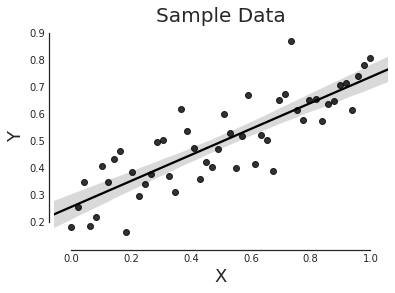

In [3]:
# Obtain sample data and plot data and model fit

x, y = theModel(num = 50)

ax = sns.regplot(x, y, fit_reg=True, color='black', label="Data")
ax.set(xlabel='X', ylabel='Y', title='Sample Data')
sns.despine(offset=5, trim=True)

-----

We also can use the _statsmodel_ library to perform an ordinary linear regression, introduced in an earlier lesson, to obtain a model fit along with fit statistics. In particular, this method provides values for our model parameters along with an estimated error (in this case the slope and intercept of the linear model being used).

-----

In [4]:
import statsmodels.formula.api as smf

# Encapsulate our test data
df = pd.DataFrame({'x': x, 'y': y})

# Implement simple regression: Result ~ Input

# First we fit slope and intercept
result = smf.ols(formula='y ~ x', data=df).fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     116.3
Date:                Mon, 19 Feb 2018   Prob (F-statistic):           2.01e-14
Time:                        21:38:54   Log-Likelihood:                 49.021
No. Observations:                  50   AIC:                            -94.04
Df Residuals:                      48   BIC:                            -90.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2567      0.026      9.944      0.000       0.205       0.309
x              0.4798      0.044     10.786      0.000       0.390       0.569
==============================================================================
Omnibus:                        1.250   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.535   Jarque-Bera (JB):                0.782
Skew:                           0.303   Prob(JB):                        0.676
Kurtosis:                       3.095   Cond. No.                         4.31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-----

[[Back to TOC]](#Table-of-Contents)

## Bayesian Analysis

These previous approaches to modeling a data set employed _frequentist_ techniques, where data are used to approximate the unknown model parameters. An alternative approach employs Bayesian statistics, where data are used to infer the likelihood distribution for the unknown model parameters. In this case, the probabilities encapsulate our _belief_ that the model parameters take on specific values. Simply put, the Bayesian approach uses data to modify our prior beliefs. While conceptually powerful, broad adoption of Bayesian approaches has been limited in the past by the computational difficulties in computing these likelihoods. However, we can now use the PyMC3 library to simplify this process. 

In the next few code cells, we import the PyMC3 library, create a model context, define our model parameters, and compute the likelihood. In this initial example, we assume our prior on the intercept is uniform between zero and one, while our prior on the slope is normally distributed about the line `y = x` with a standard deviation of one. Next we model our likelihood as a normal distribution, where the mean value is our expected value from the linear model, and the standard deviation is another normally distributed deviate.

-----

In [5]:
# The following example follows the first case study from pymc3 documentation
# http://pymc-devs.github.io/pymc3/getting_started/#case-study-1-stochastic-volatility

import pymc3 as pm

In [6]:
n_samples = 10000

with pm.Model() as linear_model:
    
    # First, define stohastic model variables
    intercept = pm.Uniform('Intercept', lower = 0, upper = 1)
    slope = pm.Normal('Slope', mu = 1.0, sd = 1.0)
        
    # Now define stochastic variable for observation errors.    
    sigma = pm.Normal('sigma', mu = 1., sd = 2.0) #beta=10, testval=1.)

    # Expected values using original indepedent variables
    # Deterministic Variable
    y_exp =  intercept + slope* x
    
    # Sample values (likelihood)
    likelihood = pm.Normal('y', mu=y_exp, sd=sigma, observed=y)

-----

[[Back to TOC]](#Table-of-Contents)


### Prior Visualization

We can visualize our prior beliefs, by computing the probability density functions for both the slope and intercept, as shown in the next Code cell.

-----

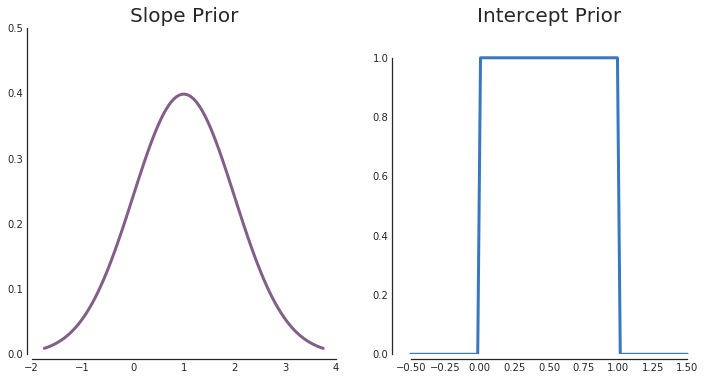

In [7]:
import scipy.stats as sts

# Compute priors
slope_rv = sts.norm(loc=1.0, scale=1.0)
intercept_rv = sts.uniform(loc=0.0, scale=1.0)

# Create figure
fig, axs = plt.subplots(figsize=(12,6), nrows=1, ncols=2)

# Plot slope prior
x_pts = np.linspace(-1.75, 3.75, 100)
axs[0].plot(x_pts, slope_rv.pdf(x_pts), c=sns.xkcd_rgb['dusty purple'], lw=3)
axs[0].set(title='Slope Prior', xlim=(-2, 4), ylim=(0.0, 0.5))

# Plot interecpt prior
x_pts = np.linspace(-0.5, 1.5, 100)
axs[1].plot(x_pts, intercept_rv.pdf(x_pts), c=sns.xkcd_rgb['windows blue'], lw=3)
axs[1].set(title='Intercept Prior', ylim=(0.0, 1.1))

sns.despine(offset=5, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)


### Sample Posterior

Given our priors and a method for sampling the likelihood of different model parameters, the next step is define a mechanism for computing model likelihoods as we move around in the parameter space defined by our chosen model (in this case the two-dimensional slope-intercept space). The standard approach for computing these quantities is known as Markov Chain Monte Carlo (MCMC). The PyMC3 library provides several different MCMC techniques, the sampler we demonstrate in this first example is the No U-Turn Sampler (or NUTS), which is a Hamiltonian MCMC sampler that is fairly robust. Another frequently used sampler is the Metropolis sampler. 

Once the sampler has been created, we can use it to create a chain of sampled parameter values, which are known as _traces_. After a (large) number of samples have been generated, these traces will provide posterior distributions for the model parameters. Thus, we can use the traces to not only obtain the model parameter values, but a statistical characterization for these values. 

-----

In [8]:
# Define MCMC sampling technique.
step = pm.NUTS(model = linear_model)

In [9]:
# Use MCMC sampler to generate model traces
trace = pm.sample(n_samples, step, 
                  model = linear_model,
                  progressbar = True)

100%|██████████| 10500/10500 [00:30<00:00, 339.05it/s]


-----

[[Back to TOC]](#Table-of-Contents)


### Trace Analysis

The trace for a given parameter provides a statistical characterization of that parameter given the data. In the next several Code cells, we demonstrate different techniques for analyzing traces. First, we create a DataFrame for the different traces, and subsequently compute statistical summaries for the two traces of interest (i.e., the slope and the intercept). Next, we graphically display the trace for these two quantities, which demonstrates how the trace fluctuates around a most likely value.

Note that, while not the case in this example, the traces often take a while to settle down to the vicinity of the most likely values. This period is known as the _burn-in_, and is generally handled by simply discarding some initial fraction of the overall samples. Standard practice varies on the problem domain, but typical values of the burn-in range from several thousand samples to nearly fifty percent of the total samples.

-----

In [10]:
df_trace = pm.trace_to_dataframe(trace)
df_trace[['Intercept', 'Slope']].describe()

,Intercept,Slope
count,10000.000000,10000.000000
mean,0.256835,0.480067
std,0.027163,0.047128
min,0.154445,0.280698
25%,0.239177,0.449018
50%,0.256764,0.480123
75%,0.274482,0.511559
max,0.349562,0.662604


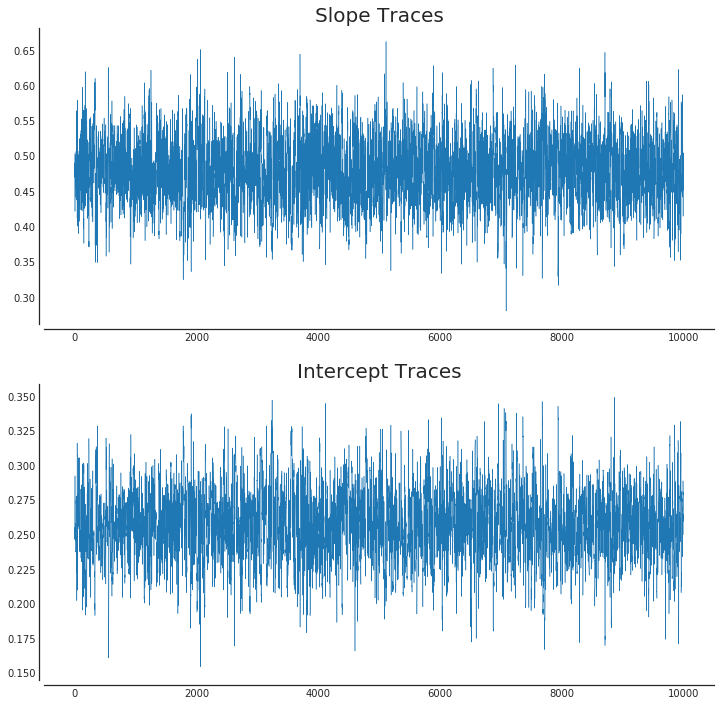

In [11]:
# Create figure
fig, axs = plt.subplots(figsize=(12,12), nrows=2, ncols=1)
sns.set_style('darkgrid')

# Plot slope traces
axs[0].plot(df_trace['Slope'], lw=0.5)
axs[0].set(title='Slope Traces')

# Plot intercept traces
axs[1].plot(df_trace['Intercept'], lw=0.5)
axs[1].set(title='Intercept Traces')

sns.despine(offset = 5, trim=False)

-----

[[Back to TOC]](#Table-of-Contents)


### Posterior Distributions

The traces, especially after removing any samples that are part of the _burn-in_, form the distributions of the model parameter values, or the Posterior of our Bayesian calculation. We can compute statistical summaries from the traces, and also plot their distributions, as shown in the following two Code cells. In both examples, we discard the first 1000 (via the `n_burn` parameter) traces as the burn-in phase.

-----

In [12]:
# Compute model parameter statistics from the traces

n_burn = 1000

print('Slope Trace Values:')
print(trace['Slope'][-10:])

print('\nSlope Trace  statistics:')
mu = np.mean(trace['Slope']) ; sigma = np.std(trace['Slope'])
print('Full Sample:  Mean = {0:4.3f}, STD = {1:4.3f}'.format(mu, sigma))
mu = np.mean(trace['Slope'][-n_burn:]) ; sigma = np.std(trace['Slope'][-n_burn:])
print('Last {0}:  Mean = {1:4.3f}, STD = {2:4.3f}'.format(n_burn, mu, sigma))

print('\nIntercept Trace Values:')
print(trace['Intercept'][-10:])

print('\nIntercept Trace statistics:')
mu = np.mean(trace['Intercept']) ; sigma = np.std(trace['Intercept'])
print('Full Sample:  Mean = {0:4.3f}, STD = {1:4.3f}'.format(mu, sigma))
mu = np.mean(trace['Intercept'][-n_burn:]) ; sigma = np.std(trace['Intercept'][-n_burn:])
print('Last {0}:  Mean = {1:4.3f}, STD = {2:4.3f}'.format(n_burn, mu, sigma))

Slope Trace Values:
[ 0.48784987  0.42558931  0.4210899   0.41492126  0.45891785  0.4280231
  0.50052322  0.49914623  0.50469154  0.45171738]

Slope Trace  statistics:
Full Sample:  Mean = 0.480, STD = 0.047
Last 1000:  Mean = 0.477, STD = 0.044

Intercept Trace Values:
[ 0.26916754  0.28907724  0.28597629  0.27890743  0.28057361  0.27942588
  0.25997341  0.26483659  0.26256496  0.25006179]

Intercept Trace statistics:
Full Sample:  Mean = 0.257, STD = 0.027
Last 1000:  Mean = 0.258, STD = 0.025


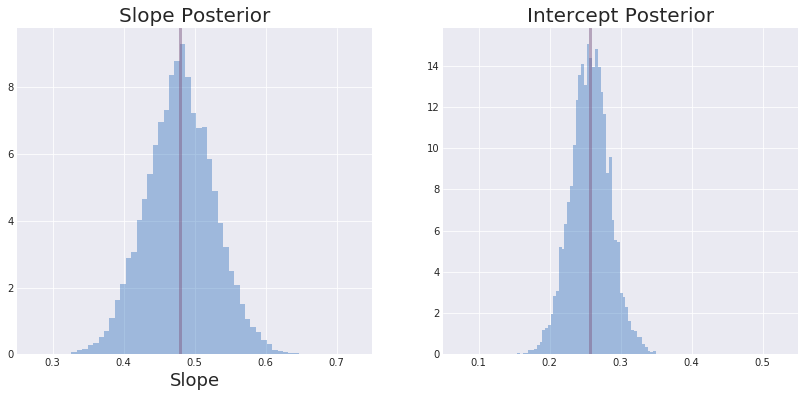

In [13]:
# Visualize the trace statistics

# Create figure
fig, axs = plt.subplots(figsize=(14,6), nrows=1, ncols=2)
sns.set_style('white')

# Plot slope posterior
sns.distplot(df_trace['Slope'][n_burn:], ax=axs[0], color=sns.xkcd_rgb['medium blue'],
             kde=False, norm_hist=True, bins=50)

mu = np.mean(df_trace['Slope'][n_burn:])
axs[0].axvline(mu, linestyle='-', color=sns.xkcd_rgb['dusty purple'], lw = 3, alpha=0.5)
axs[0].set(title='Slope Posterior', xlim=(0.25, 0.75))

# Plot intercept posterior
sns.distplot(trace['Intercept'][n_burn:], ax=axs[1], color=sns.xkcd_rgb['medium blue'],
             kde=False, norm_hist=True, bins=50)

mu = np.mean(df_trace['Intercept'][n_burn:])
axs[1].axvline(mu, linestyle='-', color=sns.xkcd_rgb['dusty purple'], lw = 3, alpha=0.5)
axs[1].set(title='Intercept Posterior', xlim=(0.05, 0.55))

sns.despine()

-----

[[Back to TOC]](#Table-of-Contents)


### Visualizing the Posterior Density

We can visualize the two-dimensional posterior in our model parameter space, which provides the joint probability of the two model parameters (slope and intercept). In the following Code cell, we use our DataFrame to make a kernel density estimate plot of the posterior density in the slope-intercept parameter space. This plot shows the negative correlation between the slope and the intercept. Note, we expect some correlation between these parameters, given our simple linear model, and the underlying data.

-----

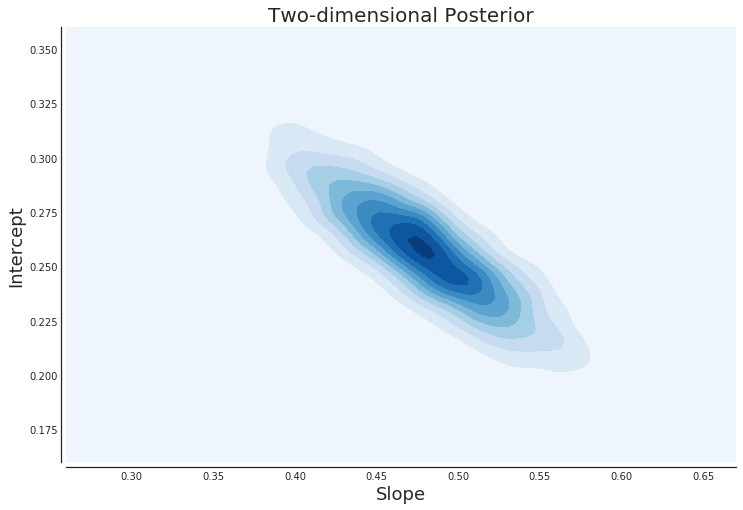

In [14]:
# Create figure
fig, axs = plt.subplots(figsize=(12,8))

# Visualize Posterior density
sns.kdeplot(df_trace.Slope[n_burn:], df_trace.Intercept[n_burn:], 
            ax=axs, cmap='Blues', shade=True)

axs.set(title='Two-dimensional Posterior', xlabel='Slope', label='Intercept',
        xlim=(0.26, 0.67), ylim=(0.16, 0.36))

sns.despine(offset=5, trim=False)

-----

[[Back to TOC]](#Table-of-Contents)


### Autocorrelation

The sampling should be a stochastic process; thus, after a small lag, there should be no correlation between samples. We can test this by computing and visualizing the autocorrelation of trace samples. In the following Code cell, we compute the autocorrelation of the slope and intercept traces. After around a lag of twenty, the traces show minimal or no correlation (i.e., they fluctuate around zero), which is a desired result.

-----

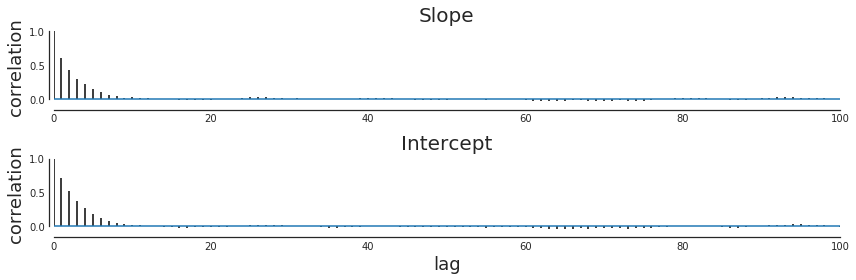

In [15]:
# Visualize the autocorrelations

sns.set_style('white')

pm.autocorrplot(trace, varnames=['Slope', 'Intercept'])
sns.despine(offset=5, trim = True)
plt.tight_layout()

-----

[[Back to TOC]](#Table-of-Contents)


## PyMC3 : Bayesian Model Fitting

Previously, we performed the Bayesian model fitting across several code cells in order to demonstrate the individual steps. Typically, however, the entire model fitting will be performed in a single pass, as demonstrated below. In this example, we perform the same model fitting, with the additional explicit computation of the maximum a posteriori estimation point. This function estimates a _good_ starting point for the sampler, which should reduce the length of the burn_in phase and should also help to achieve faster convergence.

Following the model fitting, we introduce several PyMC3 helper functions to simplify the visualization of the traces and posterior distributions (via the `traceplot` method) as well as provide  a statistical summary of the trace distributions (via the `summery` method). Finally, we compare the data, the true regression line, a number of lines corresponding to different trace samples, and the best model fit line.

-----

In [16]:
# Full model n_burn = 10000
n_samples = 20000

with pm.Model() as linear_model:
    
    # First, define stohastic model variables
    intercept = pm.Uniform('Intercept', lower = 0, upper = 1)
    slope = pm.Normal('Slope', mu = 1.0, sd = 1.0)
        
    # Now define stochastic variable for observation errors.    
    sigma = pm.Normal('sigma', mu = 1., sd = 2.0) #beta=10, testval=1.)

    # Expected values using original indepedent variables
    # Deterministic Variable
    y_exp =  intercept + slope* x
    
    # Sample values (likelihood)
    likelihood = pm.Normal('yn', mu=y_exp, sd=sigma, observed=y)
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(n_samples, step=step, start=start)

Optimization terminated successfully.
         Current function value: -44.595639
         Iterations: 17
         Function evaluations: 39
         Gradient evaluations: 31


100%|██████████| 20500/20500 [00:29<00:00, 697.02it/s]


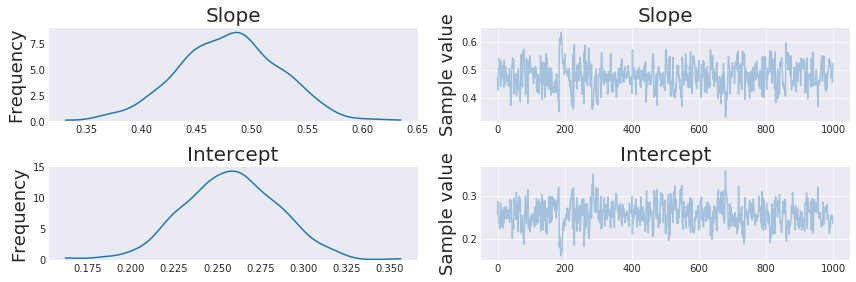

In [17]:
# Plot traces
sns.set_style('darkgrid')
pm.traceplot(trace[-n_burn:], ['Slope', 'Intercept']) ;

In [18]:
# Show trace summaries
pm.summary(trace[-n_burn:], ['Slope', 'Intercept'])


Slope:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.479            0.046            0.002            [0.392, 0.569]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.386          0.447          0.480          0.509          0.565


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.258            0.028            0.001            [0.212, 0.317]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.203          0.240          0.258          0.276          0.312



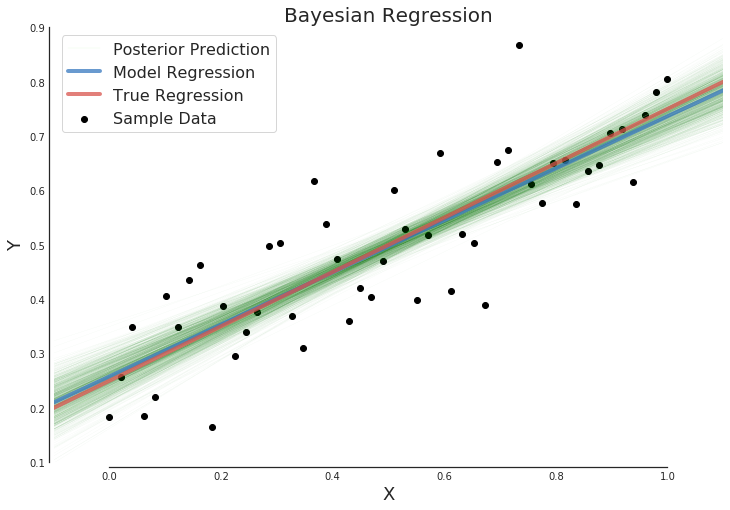

In [19]:
# Plot fits and data, only last n_smpls traces are used.
n_smpls = 1000

sns.set_style('white')

# Create figure
fig, axs = plt.subplots(figsize=(12,8))

# Plot data
axs.scatter(x, y, c='k', label = 'Sample Data')

# Plot posterior predictions
xl = -0.25 ; xh = 1.25

for m, b in zip(trace['Slope'][-n_smpls:], trace['Intercept'][-n_smpls:]):
    yl = m * xl + b ; yh = m * xh + b
    axs.plot((xl, xh), (yl, yh), color='g', lw=0.15, alpha = 0.1)

# Replot last one to get legend label
axs.plot((xl, xh), (yl, yh), color=sns.xkcd_rgb['pale green'], lw=0.15, \
         label = 'Posterior Prediction')

# Plot Model regression
m_fit = trace['Slope'][-n_smpls:].mean()
b_fit = trace['Intercept'][-n_smpls:].mean()
yfl = b_fit + m_fit * xl ; yfh = b_fit + m_fit * xh
axs.plot((xl, xh), (yfl, yfh), color=sns.xkcd_rgb['windows blue'], lw=4, 
         alpha = 0.75, label='Model Regression')

# Plot true regression
yl = b_true + m_true * xl ; yh = b_true + m_true * xh
axs.plot((xl, xh), (yl, yh), color=sns.xkcd_rgb['pale red'], lw=4, 
         alpha = 0.75, label='True Regression')

# Decorate plot
axs.set(title='Bayesian Regression', xlabel='X', ylabel='Y',
       xlim=(-0.1, 1.1), ylim=(0.1, 0.9))

axs.legend(loc='upper left', frameon=True)
sns.despine(offset=5, trim=True)

-----

<font color='red' size = '5'> Student Exercise </font>


In the preceding cells, we introduced Bayesian modeling. Now that you have run the notebook, go back and run it a second time. Notice how the data and thus model fits have changed.

1. Change the number of model points (by default there are 50 model points). How does increasing or decreasing the number of points affect the model accuracy?
2. Try changing the model parameters, does the resulting fits replicate the true model?
3. Compare the accuracy of the linear regression methods introduced earlier in the corse with the Bayesian approach. What are the benefits of the different techniques?
4. Do the distribution we use to model our priors affect the fitting? Try changing the distributions and see what changes.

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

12. Wikipedia article on [Probabilistic Programming][wpp] languages
3. Introduction to [Probabilistic Programming][gpp]
45. Overview of [Probabilistic Programming][ipp]
2. Blog article introducing [Bayesian Linear Regression][qblr]
3. Notebook introduction to [Probabilistic Programming][npp]
34. Discussion on [Bayesian A/B Testing][babt]
21. Article discussing Bayesian modeling, [Part I][bmps0], [Part II][bmps1], and [Part III][bmps2]

-----

[qblr]: https://www.quantstart.com/articles/Bayesian-Linear-Regression-Models-with-PyMC3

[npp]: https://github.com/jdwittenauer/ipython-notebooks/blob/master/notebooks/misc/ProbablisticProgramming.ipynb

[gpp]: https://github.com/zipfian/probabilistic-programming-intro

[ipp]: https://github.com/fastforwardlabs/probabilistic-programming-from-scratch/blob/master/probabilistic-programming-from-scratch.ipynb

[babt]: http://barnesanalytics.com/bayesian-poisson-ab-testing-in-pymc3-on-python

[wpp]: https://en.wikipedia.org/wiki/Probabilistic_programming_language

[aibpymc3]: http://blog.applied.ai/bayesian-inference-with-pymc3-part-1/

[tmcmc]: http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/
[bmh1]: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb

[ipymc3]: https://pymc-devs.github.io/pymc3/notebooks/getting_started.html

[bmps0]: http://nbviewer.ipython.org/github/markdregan/Bayesian-Modelling-in-Python/blob/master/Section%200.%20Introduction.ipynb
[bmps1]: http://nbviewer.jupyter.org/github/markdregan/Bayesian-Modelling-in-Python/blob/master/Section%201.%20Estimating%20model%20parameters.ipynb
[bmps2]: http://nbviewer.ipython.org/github/markdregan/Bayesian-Modelling-in-Python/blob/master/Section%202.%20Model%20checking.ipynb

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode